In [1]:
import pandas as pd
import requests
import os
from datetime import datetime
from data_creation import download_ecallisto_files, LOCAL_DATA_FOLDER
from glob import glob
from radiospectra.sources import CallistoSpectrogram
from spectogram_utils import spec_to_pd_dataframe, plot_spectogram

In [2]:
paths = download_ecallisto_files(instrument='ALASKA', return_download_paths=False)

In [174]:
files = glob(os.path.join(LOCAL_DATA_FOLDER, '**', '*ALASKA-ANCHORAGE*.fit.gz'), recursive=True)

In [275]:
test = CallistoSpectrogram.read(files[11])

In [274]:
import numpy as np
import numpy.ma as ma
def masked_spectogram_to_array(spectogram):
    """
    Converts a masked spectogram to an array
    """
    # Get row with all masked values
    idxs = np.where(~np.all(ma.getmaskarray(spectogram.data), axis=1))[0]
    # Keep only frequencies with no masked values
    spectogram.freq_axis = spectogram.freq_axis[idxs]
    # keep only rows in idxs
    data = ma.getdata(spectogram.data)
    spectogram.data = data[~np.isnan(data).any(axis=1)]
    
    return spectogram

In [266]:
spec = masked_spectogram_to_array(test)

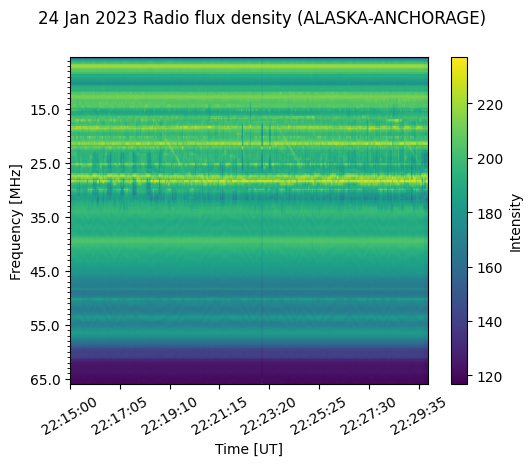

<AxesSubplot: xlabel='Time [UT]', ylabel='Frequency [MHz]'>

In [267]:
spec.peek()

In [279]:
freq_axises = []
for file in files:
    spec = CallistoSpectrogram.read(file)
    freq_axises.append(spec.freq_axis)

In [280]:
freq_before = freq_axises[0]
for freq in freq_axises[1:]:
    assert all([freq_before[i] == freq[i] for i in range(len(freq))])
    

In [276]:
test = masked_spectogram_to_array(test)

In [277]:
test_df_2 = spec_to_pd_dataframe(test)

In [129]:
import psycopg2

In [130]:
# Create variables for the connection to the OS
os.environ['PGHOST'] = 'localhost'
os.environ['PGUSER'] = 'postgres'
os.environ['PGPASSWORD'] = '1234'

##

CONNECTION = f' dbname=tsdb user={os.environ["PGUSER"]} host={os.environ["PGHOST"]} password={os.environ["PGPASSWORD"]}'

In [131]:
with psycopg2.connect(CONNECTION) as conn:
    cursor = conn.cursor()
    cursor.execute("SELECT 'hello world'")
    print(cursor.fetchone())

('hello world',)


In [283]:
with psycopg2.connect(CONNECTION) as conn:
    cursor = conn.cursor()
    cursor.execute("""SELECT table_name
  FROM information_schema.tables
 WHERE table_schema='public'
   AND table_type='BASE TABLE';
    """)
    print(cursor.fetchall())

[('sensors',), ('sensors2',), ('_1',), ('sensors3',), ('alaska_anchorage_01',)]


In [136]:
def create_table(table_name, columns):
    """
    Creates a table with the given name and columns
    """
    with psycopg2.connect(CONNECTION) as conn:
        cursor = conn.cursor()
        cursor.execute(f"""CREATE TABLE {table_name} (
                            id SERIAL PRIMARY KEY,
                            {columns}
                        );
                        """)
        conn.commit()
        cursor.close()

In [142]:
def numbers_list_to_postgresql_columns(list_, type):
    """
    Converts a list to a string. Because postgresql does not allow
    numbers as column names, the numbers are encapsulated in "".
    """
    return ', '.join([f'"{item}" {type}' for item in list_])

In [143]:
def create_instrument_table(instrument_name, frequencies, type='REAL'):
    """
    Creates a table for the given instrument with the given frequencies.
    """
    columns = numbers_list_to_postgresql_columns(frequencies, type=type)
    create_table(instrument_name, columns)
    

In [281]:
test.freq_axis

array([65.875     , 65.56300354, 65.25      , 64.93800354, 64.625     ,
       64.31300354, 64.        , 63.68799973, 63.375     , 63.06299973,
       62.75      , 62.43799973, 62.125     , 61.81299973, 61.5       ,
       61.18799973, 60.875     , 60.56299973, 60.25      , 59.93799973,
       59.625     , 59.31299973, 59.        , 58.68799973, 58.375     ,
       58.06299973, 57.75      , 57.43799973, 57.125     , 56.81299973,
       56.5       , 56.18799973, 55.875     , 55.56299973, 55.25      ,
       54.93799973, 54.625     , 54.31299973, 54.        , 53.68799973,
       53.375     , 53.06299973, 52.75      , 52.43799973, 52.125     ,
       51.81299973, 51.5       , 51.18799973, 50.875     , 50.56299973,
       50.25      , 49.93799973, 49.625     , 49.31299973, 49.        ,
       48.68799973, 48.375     , 48.06299973, 47.75      , 47.43799973,
       47.125     , 46.81299973, 46.5       , 46.18799973, 45.875     ,
       45.56299973, 45.25      , 44.93799973, 44.625     , 44.31

In [282]:
create_instrument_table('alaska_anchorage_01', test.freq_axis)

In [122]:
files

['/var/lib/ecallisto/2023/01/24/ALASKA-ANCHORAGE_20230124_234500_01.fit.gz',
 '/var/lib/ecallisto/2023/01/24/ALASKA-ANCHORAGE_20230124_210000_01.fit.gz',
 '/var/lib/ecallisto/2023/01/24/ALASKA-ANCHORAGE_20230124_230000_01.fit.gz',
 '/var/lib/ecallisto/2023/01/24/ALASKA-ANCHORAGE_20230124_213000_01.fit.gz',
 '/var/lib/ecallisto/2023/01/24/ALASKA-ANCHORAGE_20230124_220000_01.fit.gz',
 '/var/lib/ecallisto/2023/01/24/ALASKA-ANCHORAGE_20230124_231500_01.fit.gz',
 '/var/lib/ecallisto/2023/01/24/ALASKA-ANCHORAGE_20230124_193000_01.fit.gz',
 '/var/lib/ecallisto/2023/01/24/ALASKA-ANCHORAGE_20230124_194500_01.fit.gz',
 '/var/lib/ecallisto/2023/01/24/ALASKA-ANCHORAGE_20230124_001500_01.fit.gz',
 '/var/lib/ecallisto/2023/01/24/ALASKA-ANCHORAGE_20230124_000000_01.fit.gz',
 '/var/lib/ecallisto/2023/01/24/ALASKA-ANCHORAGE_20230124_223000_01.fit.gz',
 '/var/lib/ecallisto/2023/01/24/ALASKA-ANCHORAGE_20230124_221500_01.fit.gz',
 '/var/lib/ecallisto/2023/01/24/ALASKA-ANCHORAGE_20230124_224500_01.fit.gz',

In [68]:
test = list_to_postgresql_columns(["50", "40", "30"])

In [69]:
test

'"50" REAL, "40" REAL, "30" REAL'

In [71]:
create_table('sensors3', test)

In [ ]:
def fetch_spe